<a href="https://colab.research.google.com/github/JuanPabl07DP/Cardiovascular_FNN/blob/main/Cardiovascular_FNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sulianova/cardiovascular-disease-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cardiovascular-disease-dataset


In [2]:
import pandas as pd

df = pd.read_csv(f"{path}/cardio_train.csv", sep=';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
import numpy as np

# Eliminar columnas innecesarias (ID si existe)
df = df.drop(columns=['id'], errors='ignore')

# Convertir 'gender' a binario (0 = mujer, 1 = hombre)
df['gender'] = df['gender'].map({1: 1, 2: 0})

# Convertir 'age' de días a años
df['age'] = (df['age'] / 365.25).astype(int)

# Convertir 'weight' a enteros
df['weight'] = df['weight'].astype(int)

# Revisar valores extremos
df = df[(df['height'] > 100) & (df['height'] < 250)]
df = df[(df['weight'] > 30) & (df['weight'] < 200)]
df = df[(df['ap_hi'] > 70) & (df['ap_hi'] < 250)]
df = df[(df['ap_lo'] > 40) & (df['ap_lo'] < 200)]

# Normalización
from sklearn.preprocessing import MinMaxScaler

features = df.drop(columns=['cardio'])
labels = df['cardio']

scaler = MinMaxScaler()
X = features.values
y = labels.values

In [4]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,0,168,62,110,80,1,1,0,0,1,0
1,55,1,156,85,140,90,3,1,0,0,1,1
2,51,1,165,64,130,70,3,1,0,0,0,1
3,48,0,169,82,150,100,1,1,0,0,1,1
4,47,1,156,56,100,60,1,1,0,0,0,0


In [5]:
from sklearn.model_selection import train_test_split

# División
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_dev, y_train, y_dev = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp)

# Escalado
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_dev_scaled = scaler.transform(X_dev)
X_test_scaled = scaler.transform(X_test)

print(f'Train: {len(X_train)} samples')
print(f'Dev: {len(X_dev)} samples')
print(f'Test: {len(X_test)} samples')

Train: 48119 samples
Dev: 10279 samples
Test: 10306 samples


In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Dense(256, input_dim=X_train_scaled.shape[1], kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.01),
    Dropout(0.4),

    Dense(128, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.01),
    Dropout(0.3),

    Dense(64, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.01),

    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [8]:
history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_dev_scaled, y_dev),
                    epochs=40,
                    batch_size=128,
                    callbacks=[early_stop, reduce_lr],
                    verbose=1)

Epoch 1/40
376/376 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7009 - loss: 0.8179 - val_accuracy: 0.7250 - val_loss: 0.6818 - learning_rate: 5.0000e-04
Epoch 2/40
376/376 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7296 - loss: 0.6647 - val_accuracy: 0.7258 - val_loss: 0.6180 - learning_rate: 5.0000e-04
Epoch 3/40
376/376 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7332 - loss: 0.6081 - val_accuracy: 0.7291 - val_loss: 0.5883 - learning_rate: 5.0000e-04
Epoch 4/40
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7344 - loss: 0.5830 - val_accuracy: 0.7263 - val_loss: 0.5774 - learning_rate: 5.0000e-04
Epoch 5/40
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7323 - loss: 0.5717 - val_accuracy: 0.7306 - val_loss: 0.5656 - learning_rate: 5.0000e-04
Epoch 6/40
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7323 - loss: 0.5653 - val_accuracy: 0.7290 - val_loss: 0.5612 - learning_rate: 5.0000e-04
Epoch 7/40
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy:

In [9]:
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7310 - loss: 0.5476
Test Accuracy: 0.7306, Test Loss: 0.5502


In [10]:
model.save("modelo_cardio_hibrido_fnn.h5")

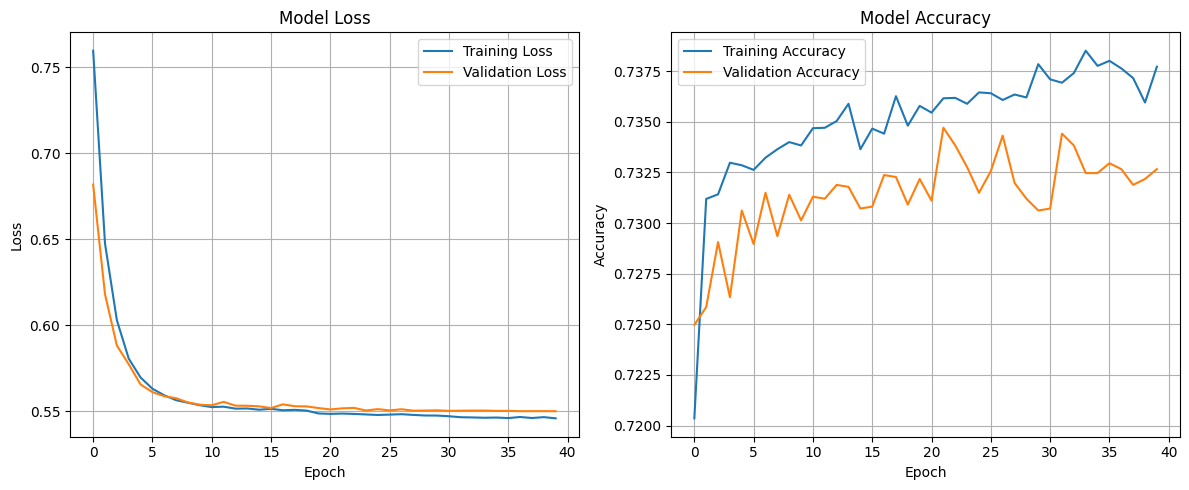

323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


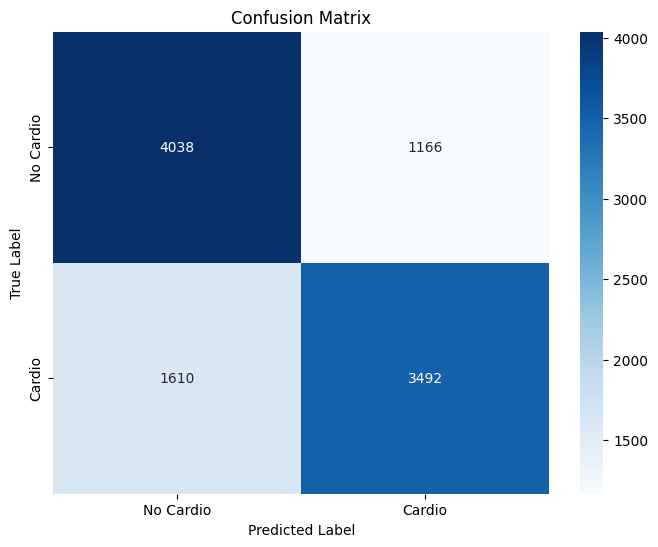

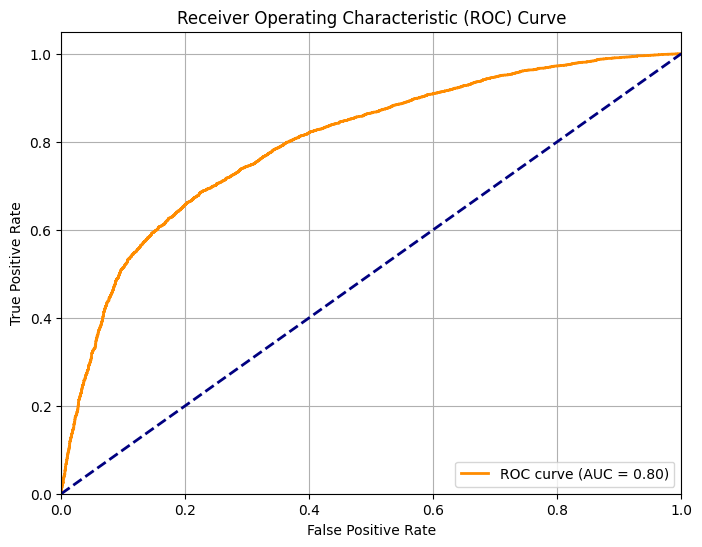

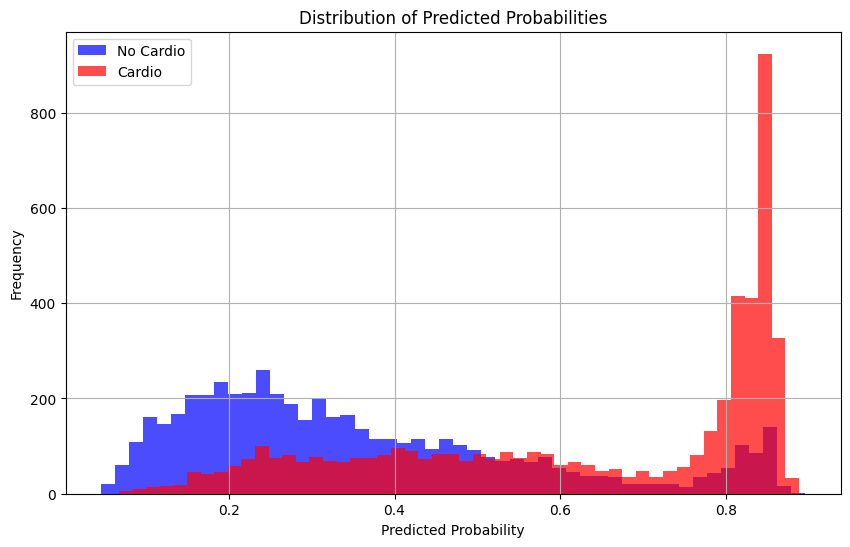


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.78      0.74      5204
           1       0.75      0.68      0.72      5102

    accuracy                           0.73     10306
   macro avg       0.73      0.73      0.73     10306
weighted avg       0.73      0.73      0.73     10306


Additional Metrics:
Precision: 0.7497
Recall: 0.6844
F1-Score: 0.7156
AUC-ROC: 0.7980


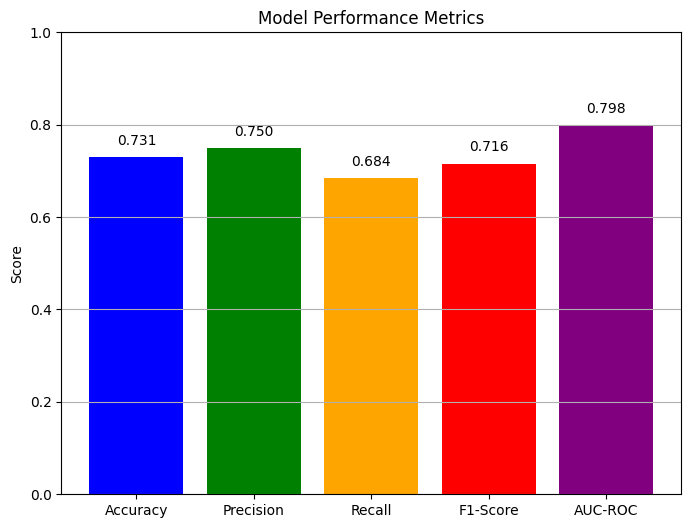

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# 1. Gráfica de pérdida y precisión durante el entrenamiento
plt.figure(figsize=(12, 5))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 2. Matriz de confusión
y_pred = model.predict(X_test_scaled)
y_pred_binary = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Cardio', 'Cardio'],
            yticklabels=['No Cardio', 'Cardio'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 3. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 4. Distribución de probabilidades predichas
plt.figure(figsize=(10, 6))
plt.hist(y_pred[y_test == 0], bins=50, alpha=0.7, label='No Cardio', color='blue')
plt.hist(y_pred[y_test == 1], bins=50, alpha=0.7, label='Cardio', color='red')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.grid(True)
plt.show()

# 5. Reporte de clasificación
print("\nClassification Report:")
print("="*40)
print(classification_report(y_test, y_pred_binary))

# 6. Métricas adicionales
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print(f"\nAdditional Metrics:")
print("="*20)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

# 7. Gráfica de barras con métricas comparativas
plt.figure(figsize=(8, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
values = [test_acc, precision, recall, f1, roc_auc]

plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red', 'purple'])
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Model Performance Metrics')
plt.grid(axis='y')

# Añadir valores en las barras
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

plt.show()